In [ ]:
from google.colab import drive
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

# Yêu cầu quyền truy cập vào Google Drive
drive.mount('/content/drive', force_remount = True)

# Đường dẫn thư mục project
project_dir = '/content/drive/My Drive/Project II/'

# Kiểm tra xem project_dir có tồn tại không trước khi thay đổi thư mục làm việc
if os.path.exists(project_dir):
    os.chdir(project_dir)
    print("Nội dung trong thư mục:")
    print(os.listdir())  # Liệt kê nội dung thư mục
else:
    print(f"Thư mục không tồn tại: {project_dir}")

Mounted at /content/drive
Nội dung trong thư mục:
['results', 'preprocess', 'data', 'models']


# **1. Khai báo thư viện**

In [ ]:
!pip install torch_geometric
!pip install torch_scatter torch_sparse -f https://data.pyg.org/whl/torch-2.6.0+cu124.html

Looking in links: https://data.pyg.org/whl/torch-2.6.0+cu124.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 118.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 123.2 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch_geometric

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.nn.modules.loss import _Loss

import torch_geometric.nn as gnn
from torch_geometric.nn import MessagePassing
from torch_geometric.typing import Adj, Tuple, Optional, Union, Tensor, SparseTensor
from torch_geometric.utils import is_sparse, to_edge_index, spmm, dropout_adj, dropout_node
from torch_geometric.nn.conv.gcn_conv import gcn_norm
from torch_geometric.data import Data

import scipy.sparse as sp
import random
from scipy.special import expit
from tqdm import tqdm
from collections import defaultdict
from torch_sparse import SparseTensor
from sklearn.preprocessing import MinMaxScaler

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# === NGCF ===
model_dir = '/content/drive/My Drive/Project II/models/ckpt/ngcf_leave_one_last.pth'

# **2. Load và chuẩn bị dữ liệu**

In [ ]:
# Load dữ liệu
data_dir = project_dir + "data/"
dataset = pd.read_csv(data_dir + "recommendations_processed.csv")

# Explicitly convert 'date' column to datetime objects
dataset['date'] = pd.to_datetime(dataset['date'])

# Loại trừ duplicate
dataset = dataset.sort_values("date") # Sort theo thời gian
dataset = dataset.drop_duplicates(subset=['user_id', 'app_id'], keep='last')

# Mapping user_id, game_id sang user_index, game_index
all_user_ids = dataset['user_id'].unique()
all_game_ids = dataset['app_id'].unique()

user_id_mapping = {user_id: idx for idx, user_id in enumerate(sorted(all_user_ids))}
game_id_mapping = {item_id: idx for idx, item_id in enumerate(sorted(all_game_ids))}

# Cập nhật lại user_id, app_id
dataset['user_id'] = dataset['user_id'].map(user_id_mapping)
dataset['app_id'] = dataset['app_id'].map(game_id_mapping)

# Chuẩn hoá cột hours_log
scaler = MinMaxScaler(feature_range=(0,1))
hours_norm = scaler.fit_transform(dataset[['hours_log']]).squeeze()
dataset['hours_norm'] = hours_norm

## **2.1. Chia dataset theo chiến lược Leave One Last**

In [ ]:
def split_data_leave_one_last(df):
    df = df.copy().reset_index(names='original_index')
    test_indices = []

    for _, group in df.groupby("user_id"):
        group_sorted = group.sort_values("date")
        is_rec = group_sorted["is_recommended"].values
        idx = group_sorted.index.values
        for i in range(len(is_rec) - 1, -1, -1):
            if is_rec[i] == 1:
                test_indices.extend(idx[i:])
                break

    test_set = df.loc[test_indices].reset_index(drop=True)
    train_set = df.drop(index=test_indices).reset_index(drop=True)
    test_set = test_set.drop(columns=["original_index"])
    train_set = train_set.drop(columns=["original_index"])
    return train_set, test_set

train_df, test_df = split_data_leave_one_last(dataset)
train_df, valid_df = split_data_leave_one_last(train_df)

print(f"train_df: {train_df.shape}")
print(f"valid_df: {valid_df.shape}")
print(f"test_df: {test_df.shape}")

train_df: (2409713, 9)
valid_df: (64265, 9)
test_df: (61055, 9)


## **2.2. Thống kê dataset đơn giản**

In [ ]:
# Số lượng users, games
num_users = len(all_user_ids)
num_games = len(all_game_ids)
num_nodes = num_users + num_games

print(f"Số lượng users: {num_users}")
print(f"Số lượng games: {num_games}")
print(f"Số lượng nodes: {num_nodes}")

# Print cold-start statistics
train_users = set(train_df['user_id'].unique())
train_items = set(train_df['app_id'].unique())

valid_users = set(valid_df['user_id'].unique())
valid_items = set(valid_df['app_id'].unique())

test_users = set(test_df['user_id'].unique())
test_items = set(test_df['app_id'].unique())

valid_cold_start_users = valid_users - train_users
valid_cold_start_items = valid_items - train_items
test_cold_start_users = test_users - train_users
test_cold_start_items = test_items - train_items

print("\n=== Cold-start analysis in valid ===")
print(f"Total users in valid: {len(valid_users)}")
print(f"--> Cold-start users in valid: {len(valid_cold_start_users)}")
print(f"Total items in valid: {len(valid_items)}")
print(f"--> Cold-start games in valid: {len(valid_cold_start_items)}")

print("\n=== Cold-start analysis in test ===")
print(f"Total users in test: {len(test_users)}")
print(f"--> Cold-start users in test: {len(test_cold_start_users)}")
print(f"Total items in test: {len(test_items)}")
print(f"--> Cold-start games in test: {len(test_cold_start_items)}")

Số lượng users: 47274
Số lượng games: 4632
Số lượng nodes: 51906

=== Cold-start analysis in valid ===
Total users in valid: 47274
--> Cold-start users in valid: 0
Total items in valid: 4128
--> Cold-start games in valid: 1

=== Cold-start analysis in test ===
Total users in test: 47274
--> Cold-start users in test: 0
Total items in test: 3903
--> Cold-start games in test: 1


# **3. Định nghĩa các hàm tiện ích**

## **3.1. Hàm xây dựng ma trận tương tác user-item**

In [ ]:
def create_interact_matrix(dataset: pd.DataFrame,
                               num_users: int,
                               num_items: int) -> torch.BoolTensor:
    # Chỉ lấy các tương tác positive trên toàn bộ dataset
    pos_df = dataset[dataset['is_recommended'] == 1]
    rows = pos_df['user_id'].to_numpy()
    cols = pos_df['app_id'].to_numpy()
    data = np.ones_like(rows, dtype=np.bool_)
    mat = sp.coo_matrix((data, (rows, cols)), shape=(num_users, num_items))
    return torch.from_numpy(mat.toarray())  # dtype=bool mặc định

full_matrix = create_interact_matrix(dataset, num_users, num_games)

## **3.2. Hàm xây dựng đồ thị hai phía (bipartite graph)**

In [ ]:
def create_edge_index_and_weight(data_df, num_users: int):
    # Chọn các cạnh dương (is_recommended == 1)
    pos_mask = data_df['is_recommended'] == 1

    # Lấy mảng user_id và app_id (đã shift)
    users = data_df.loc[pos_mask, 'user_id'].values
    items = data_df.loc[pos_mask, 'app_id'].values + num_users

    # Stack thành numpy array shape (2, N)
    edge_index_np = np.stack([users, items], axis=0)
    pos_edges = torch.from_numpy(edge_index_np).long()

    # Lấy mảng weights tương ứng
    # hours_norm đã nằm trong [0,1]
    edge_weights = data_df.loc[pos_mask, 'hours_norm'].values
    pos_edge_weight = torch.from_numpy(edge_weights).float()

    return pos_edges, pos_edge_weight

train_edge_index, train_edge_weight = create_edge_index_and_weight(train_df, num_users)
valid_edge_index, valid_edge_weight = create_edge_index_and_weight(valid_df, num_users)

train_adj = SparseTensor(row=train_edge_index[0],
                         col=train_edge_index[1],
                         value=train_edge_weight,
                         sparse_sizes=(num_nodes, num_nodes))
valid_adj = SparseTensor(row=valid_edge_index[0],
                         col=valid_edge_index[1],
                         value=valid_edge_weight,
                         sparse_sizes=(num_nodes, num_nodes))

## **3.3. Hàm định nghĩa các Ranking Metrics**

In [ ]:
def precision_at_k(scores: torch.Tensor, labels: torch.Tensor, k: int) -> torch.Tensor:
    topk = torch.topk(scores, k, dim=1).indices
    hits = torch.gather(labels, 1, topk)
    return hits.sum(dim=1) / k

def recall_at_k(scores: torch.Tensor, labels: torch.Tensor, k: int) -> torch.Tensor:
    topk = torch.topk(scores, k, dim=1).indices
    hits = torch.gather(labels, 1, topk)
    relevant = labels.sum(dim=1).clamp(min=1e-8)  # avoid divide by zero
    return hits.sum(dim=1) / relevant

def ndcg_at_k(scores: torch.Tensor, labels: torch.Tensor, k: int) -> torch.Tensor:
    device = scores.device
    topk = torch.topk(scores, k, dim=1).indices
    hits = torch.gather(labels, 1, topk)

    weights = torch.log2(torch.arange(2, k + 2, device=device).float())
    dcg = (hits / weights).sum(dim=1)

    ideal_len = labels.sum(dim=1).clamp(max=k).long()
    idcg = torch.stack([
        (1.0 / weights[:L]).sum() if L > 0 else torch.tensor(0.0, device=device)
        for L in ideal_len
    ])
    return dcg / idcg.clamp(min=1e-8)

def hitrate_at_k(scores: torch.Tensor, labels: torch.Tensor, k: int) -> torch.Tensor:
    topk = torch.topk(scores, k, dim=1).indices
    hits = torch.gather(labels, 1, topk)
    return (hits.sum(dim=1) > 0).float()

## **3.4. Hàm mất mát BPR Loss**

In [ ]:
class BPRLoss(_Loss):
    def __init__(self, lambda_reg: float = 1e-3):
        super().__init__()
        self.lambda_reg = lambda_reg

    def forward(self,
                pos_score: Tensor,
                neg_score: Tensor,
                parameters: Tensor = None) -> Tensor:
        """
        pos_score: [batch_size]
        neg_score: [batch_size, num_neg]
        parameters: embedding cần regularize
        """
        # Ensure pos_score has shape [batch_size, 1] for broadcasting
        if pos_score.dim() == 1:
            pos_score = pos_score.unsqueeze(1)  # [batch_size, 1]

        log_prob = F.logsigmoid(pos_score - neg_score).mean()

        regularization = 0
        if self.lambda_reg != 0 and parameters is not None:
            regularization = self.lambda_reg * parameters.norm(p=2).pow(2)
            regularization = regularization / pos_score.size(0)

        return -log_prob + regularization

# **4. Định nghĩa mô hình**

## **4.1. NGCFConv**

In [ ]:
class NGCFConv(MessagePassing):
    def __init__(self,
                 embedding_dim: int = 64,
                 aggr: str = 'add', flow: str = 'source_to_target',
                 mess_dropout_prob: float = 0.2,
                 node_dropout_prob: float = 0.6,
                 norm = gcn_norm):
        super(NGCFConv, self).__init__(aggr=aggr, flow=flow)
        self.embedding_dim = embedding_dim
        self.mess_dropout_prob = mess_dropout_prob
        self.node_dropout_prob = node_dropout_prob
        self.activation = nn.LeakyReLU(negative_slope=0.2)
        self.norm = norm
        # Weight matrices W1 and W2
        self.lin1 = nn.Linear(embedding_dim, embedding_dim, bias=False)
        self.lin2 = nn.Linear(embedding_dim, embedding_dim, bias=False)
        # Message Dropout Layer
        self.mess_dropout_layer = nn.Dropout(self.mess_dropout_prob)
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.lin1.weight)
        nn.init.xavier_uniform_(self.lin2.weight)

    def forward(self, x: Tensor,
                edge_index: SparseTensor,
                edge_weight: Tensor = None) -> Tensor:
        if isinstance(edge_index, SparseTensor):
            # === Apply Normalization ===
            edge_index = self.norm(edge_index, None, x.size(self.node_dim),
                                    add_self_loops=False, flow=self.flow, dtype=x.dtype)

            # === Node Dropout ===
            if self.training and self.node_dropout_prob > 0:
                # Get edge indices from SparseTensor
                row, col, _ = edge_index.coo()
                ei = torch.stack([row, col], dim=0)

                # Apply node dropout
                ei, edge_mask, node_mask = dropout_node(
                    ei,
                    p=self.node_dropout_prob,
                    num_nodes=x.size(self.node_dim),
                    training=True
                )

                # Create new SparseTensor with dropped edges
                if edge_weight is not None:
                    edge_weight = edge_weight[edge_mask] if edge_weight.size(0) == edge_mask.size(0) else edge_weight

                edge_index = SparseTensor.from_edge_index(
                    edge_index=ei,
                    sparse_sizes=edge_index.sizes()
                ).to(ei.device)
        else:
            raise ValueError("Unsupported edge_index type.")

        return self.propagate(edge_index, x=x, edge_weight=edge_weight)

    def message(self, x_j: Tensor,
                x_i: Tensor, edge_weight: Tensor = None) -> Tensor:
        msg = self.lin1(x_j) + self.lin2(x_i * x_j)
        if edge_weight is not None:
            msg = edge_weight.view(-1, 1) * msg
        # === Message Dropout ===
        if self.training and self.mess_dropout_prob > 0:
            msg = self.mess_dropout_layer(msg)
        return msg

    def message_and_aggregate(self, adj_t: Adj, x: Tensor) -> Tensor:
        msg = self.lin1(x) + self.lin2(x * x)
        # === Message Dropout ===
        if self.training and self.mess_dropout_prob > 0:
            msg = self.mess_dropout_layer(msg)
        return spmm(adj_t, msg, reduce=self.aggr)

    def update(self, aggr_out: Tensor) -> Tensor:
        return self.activation(aggr_out)

## **4.2. NGCF Model**

In [ ]:
class NGCF(nn.Module):
    def __init__(self,
                 num_users: int,
                 num_items: int,
                 embedding_dim: int = 64,
                 num_layers: int = 3,
                 mess_dropout_prob: float = 0.2,
                 node_dropout_prob: float = 0.4,
                 norm=gcn_norm):
        super(NGCF, self).__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.num_nodes = num_users + num_items
        self.embedding_dim = embedding_dim
        # Embedding Layer
        self.embedding = nn.Embedding(self.num_nodes, embedding_dim)
        # Embedding Propagation Layer
        self.convs = nn.ModuleList()
        for _ in range(num_layers):
            self.convs.append(
                NGCFConv(embedding_dim=embedding_dim,
                         mess_dropout_prob=mess_dropout_prob,
                         node_dropout_prob=node_dropout_prob,
                         norm=norm)
            )
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.embedding.weight)
        for conv in self.convs:
            conv.reset_parameters()

    def get_embedding(self, edge_index: SparseTensor, edge_weight: Tensor = None) -> Tensor:
        """
        Thực hiện L bước propagation và trả về tensor [N, (L+1)*D]
        chứa embedding gốc (layer 0) và embedding sau mỗi convolution.
        """
        x = self.embedding.weight
        all_emb = [x]
        for conv in self.convs:
            x = conv(x, edge_index, edge_weight)
            all_emb.append(x)
        return torch.cat(all_emb, dim=1)

    def forward(self, edge_index: SparseTensor,
                edge_label_index: Tensor,
                edge_weight: Tensor = None) -> Tensor:
        emb = self.get_embedding(edge_index, edge_weight)
        emb_src = emb[edge_label_index[0]]
        emb_dist = emb[edge_label_index[1]]
        scores = (emb_src * emb_dist).sum(dim=-1)
        return scores

    def compute_bpr_loss(self, pos_scores: Tensor, neg_scores: Tensor, lambda_reg: float = 1e-3) -> Tensor:
        """
        Tính BPR Loss, bao gồm cả phần regularization L2 cho TẤT CẢ các tham số có thể học được của mô hình.
        """
        loss_fn = BPRLoss(lambda_reg=lambda_reg)

        # Thu thập TẤT CẢ các tham số của mô hình
        all_learnable_parameters = []
        for name, param in self.named_parameters():
            if param.requires_grad:
                # print(f"Regularizing parameter: {name}, shape: {param.shape}")
                all_learnable_parameters.append(param.view(-1)) # Làm phẳng và thêm vào danh sách

        # Nối tất cả các tensor tham số đã làm phẳng thành một tensor lớn
        if all_learnable_parameters:
            concatenated_params = torch.cat(all_learnable_parameters)
        else:
            concatenated_params = None # Không có tham số để regularize

        return loss_fn(pos_scores, neg_scores, concatenated_params)

# **5. Huấn luyện mô hình**

## **5.1. Định nghĩa hàm train**

In [ ]:
def train(model, train_data, train_loader, scheduler, optimizer, device, lambda_reg=1e-3, criterion='bpr', num_neg = 3):
    model.train()
    total_loss = 0.0
    total_examples = 0

    num_users = model.num_users
    num_items = model.num_items

    adj = train_data.edge_index
    pos_edge_label_index = train_data.edge_label_index
    pos_edge_weight = train_data.edge_weight
    all_neg_items = train_data.all_neg_items
    user_to_train_idx = train_data.user_to_train_idx

    for batch_index in tqdm(train_loader, desc="Training", leave=False):
        # === Positive Samples ===
        batch_pos_edge_label_index = pos_edge_label_index[:, batch_index]
        batch_users = batch_pos_edge_label_index[0]
        batch_pos_items = batch_pos_edge_label_index[1]
        batch_pos_edge_weight = pos_edge_weight[batch_index]
        batch_size = batch_users.size(0)

        # === Negative Sampling ===
        batch_train_indices = torch.tensor(
            [user_to_train_idx[u.item()] for u in batch_users],
            dtype=torch.long, device=device
        )
        user_neg_items = all_neg_items[batch_train_indices]  # [batch_size, num_items]
        neg_items = torch.multinomial(user_neg_items.float(), num_samples=num_neg, replacement=True)  # [batch_size, num_neg]

        # Expand users to match negative samples
        batch_neg_users = batch_users.unsqueeze(1).expand(-1, num_neg).reshape(-1)  # [batch_size * num_neg]
        batch_neg_items = (neg_items + num_users).reshape(-1)  # [batch_size * num_neg]
        batch_neg_edge_label_index = torch.stack([batch_neg_users, batch_neg_items], dim=0)

        # === Compute scores ===
        pos_scores = model(adj, batch_pos_edge_label_index, batch_pos_edge_weight)  # [batch_size]
        neg_scores = model(adj, batch_neg_edge_label_index, None)  # [batch_size * num_neg]
        neg_scores = neg_scores.view(batch_size, num_neg)  # [batch_size, num_neg]

        batch_nodes = torch.unique(torch.cat([batch_users, batch_pos_items, batch_neg_items]))

        optimizer.zero_grad()
        if criterion == 'bpr':
            loss = model.compute_bpr_loss(pos_scores=pos_scores,
                                          neg_scores=neg_scores,
                                          lambda_reg=lambda_reg)
        else:
            raise ValueError(f"Unknown Loss Type: {criterion}")

        loss.backward()
        optimizer.step()

        total_loss += loss.item() * batch_size
        total_examples += batch_size

    scheduler.step()
    train_loss = total_loss / total_examples
    return train_loss

## **5.2. Định nghĩa hàm validate**

In [ ]:
@torch.no_grad()
def validate(model, valid_data, valid_loader, device, criterion='bpr', num_neg = 3):
    model.eval()
    total_loss = 0.0
    total_examples = 0

    num_users = model.num_users

    adj = valid_data.edge_index
    pos_edge_label_index = valid_data.edge_label_index
    pos_edge_weight = valid_data.edge_weight
    user_to_valid_idx = valid_data.user_to_valid_idx
    all_neg_items = valid_data.all_neg_items

    for batch_index in tqdm(valid_loader, desc="Validating", leave=False):
        batch_pos_edge_label_index = pos_edge_label_index[:, batch_index]
        batch_users = batch_pos_edge_label_index[0]
        batch_pos_items = batch_pos_edge_label_index[1]
        batch_pos_edge_weight = pos_edge_weight[batch_index]
        batch_size = batch_users.size(0)

        batch_valid_indices = torch.tensor(
            [user_to_valid_idx[u.item()] for u in batch_users],
            dtype=torch.long, device=device
        )
        user_neg_items = all_neg_items[batch_valid_indices]
        neg_items = torch.multinomial(user_neg_items.float(), num_samples=num_neg, replacement=True)

        batch_neg_users = batch_users.unsqueeze(1).expand(-1, num_neg).reshape(-1)
        batch_neg_items = (neg_items + num_users).reshape(-1)
        batch_neg_edge_label_index = torch.stack([batch_neg_users, batch_neg_items], dim=0)

        pos_scores = model(adj, batch_pos_edge_label_index, batch_pos_edge_weight)
        neg_scores = model(adj, batch_neg_edge_label_index, None).view(batch_size, num_neg)

        batch_nodes = torch.unique(torch.cat([batch_users, batch_pos_items, batch_neg_items]))

        loss = model.compute_bpr_loss(pos_scores=pos_scores,
                                      neg_scores=neg_scores,
                                      lambda_reg=0.0)

        total_loss += loss.item() * batch_size
        total_examples += batch_size

    valid_loss = total_loss / total_examples if total_examples > 0 else 0.0
    return valid_loss

## **5.3. Định nghĩa hàm evaluate**

In [ ]:
@torch.no_grad()
def evaluate_ranking_leave_one_last(model, test_data, device, k=10, batch_size=4096):
    """
    Evaluate model using leave-one-last strategy.
    For each user:
    - One recent positive item
    - 100 random negative items
    """
    model.eval()

    # Get embeddings
    emb = model.embedding.weight
    num_users = model.num_users
    item_emb = emb[num_users:]

    # Get test data
    test_labels = test_data.labels
    train_interactions = test_data.train_interactions
    user_ids = test_data.user_ids
    eval_mask = test_data.eval_mask

    # Ensure item embeddings match the game list
    item_emb = item_emb[:len(test_data.game_list)]

    # Metrics storage
    all_ndcg = []
    all_hit = []

    num_test = user_ids.size(0)

    # Process in batches
    for start in tqdm(range(0, num_test, batch_size), desc="Evaluating", leave=False):
        end = min(start + batch_size, num_test)
        batch_idx = slice(start, end)
        batch_user_ids = user_ids[batch_idx]

        # Get user embeddings
        batch_u_emb = emb[batch_user_ids]

        # Compute scores for all items
        batch_scores = batch_u_emb @ item_emb.T

        # Mask out items not in evaluation set
        batch_scores = batch_scores.masked_fill(~eval_mask[batch_idx], -float('inf'))
        batch_labels = test_labels[batch_idx]

        # Skip users with no positive labels
        valid_users = batch_labels.sum(dim=1) > 0
        if not valid_users.any():
            continue

        batch_scores = batch_scores[valid_users]
        batch_labels = batch_labels[valid_users]

        # Compute metrics
        ndcg = ndcg_at_k(batch_scores, batch_labels, k)
        hitrate = hitrate_at_k(batch_scores, batch_labels, k)

        all_ndcg.append(ndcg)
        all_hit.append(hitrate)

    # Compute average metrics
    avg_ndcg = torch.cat(all_ndcg).mean().item() if all_ndcg else 0.0
    avg_hit = torch.cat(all_hit).mean().item() if all_hit else 0.0

    return {
        f"NDCG@{k}": avg_ndcg,
        f"HitRate@{k}": avg_hit
    }

## **5.4. Train Loss, Valid Loss, NDCG@10, HitRate@10**

### **5.4.1. Chuẩn bị dữ liệu trước khi huấn luyện**

In [ ]:
train_users_tensor = torch.tensor(list(train_users), dtype=torch.long)
train_num_users = train_users_tensor.size(0)

# Create mapping from global user indices to training user indices
user_to_train_idx = {u.item(): i for i, u in enumerate(train_users_tensor)}

# Pre-compute all possible negative items for each user in train dataset
train_all_neg_items = torch.zeros((train_num_users, num_games), dtype = torch.bool)
for i, u in enumerate(train_users_tensor):
    train_all_neg_items[i] = ~full_matrix[u]

train_data = Data(
    edge_index = train_adj,
    edge_label_index = train_edge_index,
    edge_weight = train_edge_weight,
    all_neg_items = train_all_neg_items,
    user_to_train_idx = user_to_train_idx
).to(device)

train_loader = DataLoader(
    dataset = range(train_data.edge_label_index.size(1)), # range(E)
    batch_size = 8192,
    shuffle = True,
    num_workers = 2,
    pin_memory = True,  # Faster data transfer to GPU
    persistent_workers = True  # Keep workers alive between epochs
)

In [ ]:
valid_users_tensor = torch.tensor(list(set(valid_users)), dtype=torch.long)
valid_num_users = valid_users_tensor.size(0)

# Create mapping from global user indices to validation user indices
user_to_valid_idx = {u.item(): i for i, u in enumerate(valid_users_tensor)}

# Pre-compute all possible negative items for each user in valid dataset
valid_all_neg_items = torch.zeros((valid_num_users, num_games), dtype=torch.bool)
for i, u in enumerate(valid_users_tensor):
    valid_all_neg_items[i] = ~full_matrix[u]

valid_data = Data(
    edge_index = valid_adj,
    edge_label_index = valid_edge_index,
    edge_weight = valid_edge_weight,
    all_neg_items = valid_all_neg_items,
    user_to_valid_idx = user_to_valid_idx,
).to(device)

valid_loader = DataLoader(
    dataset = range(valid_data.edge_label_index.size(1)),
    batch_size = 8192,
    shuffle = False,
    num_workers = 2,
    pin_memory = True,
    persistent_workers = True
)

In [ ]:
def create_leave_one_last_data(train_df, test_df, device, num_neg_samples=100):
    """
    Create test data for leave-one-last evaluation strategy.
    For each user:
    - One recent positive item from test set
    - 100 random negative items from training set
    """
    # Get unique games from training set
    game_list = sorted(train_df["app_id"].unique())
    game2idx = {game_id: idx for idx, game_id in enumerate(game_list)}
    num_games = len(game_list)

    # Get test users and their positive items
    test_users = test_df["user_id"].unique()
    user2idx = {user_id: idx for idx, user_id in enumerate(test_users)}
    num_test_users = len(test_users)

    # Create user-item interaction matrix for training
    train_interactions = torch.zeros((num_test_users, num_games), dtype=torch.bool, device=device)
    for user_id, game_id in zip(train_df["user_id"], train_df["app_id"]):
        if user_id in user2idx and game_id in game2idx:
            u_idx = user2idx[user_id]
            g_idx = game2idx[game_id]
            train_interactions[u_idx, g_idx] = True

    # Create test labels (one positive item per user)
    test_labels = torch.zeros((num_test_users, num_games), dtype=torch.float, device=device)
    for user_id, game_id in zip(test_df["user_id"], test_df["app_id"]):
        if user_id in user2idx and game_id in game2idx:
            u_idx = user2idx[user_id]
            g_idx = game2idx[game_id]
            test_labels[u_idx, g_idx] = 1.0

    # Create mask for items to evaluate (positive + 100 negative)
    eval_mask = torch.zeros((num_test_users, num_games), dtype=torch.bool, device=device)

    for i, user_id in enumerate(test_users):
        u_idx = user2idx[user_id]

        # Get positive item from test set
        pos_items = torch.where(test_labels[u_idx] == 1)[0]
        if len(pos_items) > 0:
            eval_mask[u_idx, pos_items[0]] = True

        # Get negative items from training set
        neg_items = torch.where(~train_interactions[u_idx])[0]
        if len(neg_items) >= num_neg_samples:
            # Randomly select num_neg_samples negative items
            selected_neg = neg_items[torch.randperm(len(neg_items))[:num_neg_samples]]
            eval_mask[u_idx, selected_neg] = True

    # Create user IDs tensor
    user_ids_tensor = torch.tensor(test_users, dtype=torch.long, device=device)

    return Data(
        labels=test_labels,
        train_interactions=train_interactions,
        user_ids=user_ids_tensor,
        eval_mask=eval_mask,
        game_list=game_list
    )

In [ ]:
evaluate_data = create_leave_one_last_data(train_df, valid_df, device)

### **5.4.2. Khởi tạo mô hình và huấn luyện**

In [ ]:
model = NGCF(
    num_users = num_users,
    num_items = num_games,
    embedding_dim = 64,
    num_layers = 3,
    mess_dropout_prob = 0.4,
    node_dropout_prob = 0.6
).to(device)


print("Tham số của mô hình:")
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"param_name: {name}, param_size: {param.size()}, requires_grad: {param.requires_grad}")

Tham số của mô hình:
param_name: embedding.weight, param_size: torch.Size([51906, 64]), requires_grad: True
param_name: convs.0.lin1.weight, param_size: torch.Size([64, 64]), requires_grad: True
param_name: convs.0.lin2.weight, param_size: torch.Size([64, 64]), requires_grad: True
param_name: convs.1.lin1.weight, param_size: torch.Size([64, 64]), requires_grad: True
param_name: convs.1.lin2.weight, param_size: torch.Size([64, 64]), requires_grad: True
param_name: convs.2.lin1.weight, param_size: torch.Size([64, 64]), requires_grad: True
param_name: convs.2.lin2.weight, param_size: torch.Size([64, 64]), requires_grad: True


In [ ]:
optimizer = optim.Adam(model.parameters(), lr = 0.01)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = 50, eta_min = 0.0005)
num_epochs = 50

train_losses, valid_losses, ndcgs_10, hitrates_10 = [], [], [], []
best_ndcg_10 = 0.0
best_hitrate_10 = 0.0

for epoch in range(1, num_epochs + 1):
    train_loss = train(
      model = model,
      train_data = train_data,
      train_loader = train_loader,
      optimizer = optimizer,
      scheduler = scheduler,
      device = device,
      lambda_reg = 1e-3,
      criterion = 'bpr',
      num_neg = 3
    )

    valid_loss = validate(
      model = model,
      valid_data = valid_data,
      valid_loader = valid_loader,
      device = device,
      criterion = 'bpr',
      num_neg = 3
    )

    evaluation_results = evaluate_ranking_leave_one_last(model = model,
                                                         test_data = evaluate_data,
                                                         device = device)

    ndcg_10 = evaluation_results["NDCG@10"]
    hitrate_10 = evaluation_results["HitRate@10"]

    print(f"Epoch: {epoch:02d} | Train Loss: {train_loss:.4f} | Valid Loss: {valid_loss:.4f} | NDCG@10: {ndcg_10:.4f} | HitRate@10: {hitrate_10:.4f}")

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    ndcgs_10.append(ndcg_10)
    hitrates_10.append(hitrate_10)

    if ndcg_10 > best_ndcg_10 and hitrate_10 > best_hitrate_10:
        best_ndcg_10 = ndcg_10
        best_hitrate_10 = hitrate_10
        if os.path.exists(model_dir):
            os.remove(model_dir)
        torch.save(model.state_dict(), model_dir)
        print("---> Best checkpoint is saved!")

Epoch: 01 | Train Loss: 0.4154 | Valid Loss: 0.4300 | NDCG@10: 0.2416 | HitRate@10: 0.4812
---> Best checkpoint is saved!


Epoch: 02 | Train Loss: 0.2339 | Valid Loss: 0.3619 | NDCG@10: 0.2706 | HitRate@10: 0.5285
---> Best checkpoint is saved!


Epoch: 03 | Train Loss: 0.1939 | Valid Loss: 0.3437 | NDCG@10: 0.2793 | HitRate@10: 0.5422
---> Best checkpoint is saved!


Epoch: 04 | Train Loss: 0.1735 | Valid Loss: 0.3405 | NDCG@10: 0.2827 | HitRate@10: 0.5486
---> Best checkpoint is saved!


Epoch: 05 | Train Loss: 0.1627 | Valid Loss: 0.3385 | NDCG@10: 0.2848 | HitRate@10: 0.5516
---> Best checkpoint is saved!


Epoch: 06 | Train Loss: 0.1559 | Valid Loss: 0.3397 | NDCG@10: 0.2843 | HitRate@10: 0.5492


Epoch: 07 | Train Loss: 0.1521 | Valid Loss: 0.3484 | NDCG@10: 0.2845 | HitRate@10: 0.5488


Epoch: 08 | Train Loss: 0.1493 | Valid Loss: 0.3482 | NDCG@10: 0.2844 | HitRate@10: 0.5487


Epoch: 09 | Train Loss: 0.1474 | Valid Loss: 0.3601 | NDCG@10: 0.2840 | HitRate@10: 0.5452


Epoch: 10 | Train Loss: 0.1457 | Valid Loss: 0.3535 | NDCG@10: 0.2848 | HitRate@10: 0.5450


Epoch: 11 | Train Loss: 0.1435 | Valid Loss: 0.3570 | NDCG@10: 0.2864 | HitRate@10: 0.5490


Epoch: 12 | Train Loss: 0.1421 | Valid Loss: 0.3551 | NDCG@10: 0.2851 | HitRate@10: 0.5462


Epoch: 13 | Train Loss: 0.1409 | Valid Loss: 0.3550 | NDCG@10: 0.2862 | HitRate@10: 0.5494


Epoch: 14 | Train Loss: 0.1391 | Valid Loss: 0.3608 | NDCG@10: 0.2865 | HitRate@10: 0.5488


Epoch: 15 | Train Loss: 0.1376 | Valid Loss: 0.3547 | NDCG@10: 0.2864 | HitRate@10: 0.5482


Epoch: 16 | Train Loss: 0.1363 | Valid Loss: 0.3562 | NDCG@10: 0.2862 | HitRate@10: 0.5483


Epoch: 17 | Train Loss: 0.1347 | Valid Loss: 0.3558 | NDCG@10: 0.2869 | HitRate@10: 0.5495


Epoch: 18 | Train Loss: 0.1330 | Valid Loss: 0.3556 | NDCG@10: 0.2883 | HitRate@10: 0.5504


Epoch: 19 | Train Loss: 0.1319 | Valid Loss: 0.3495 | NDCG@10: 0.2886 | HitRate@10: 0.5526
---> Best checkpoint is saved!


Epoch: 20 | Train Loss: 0.1300 | Valid Loss: 0.3504 | NDCG@10: 0.2899 | HitRate@10: 0.5532
---> Best checkpoint is saved!


Epoch: 21 | Train Loss: 0.1289 | Valid Loss: 0.3471 | NDCG@10: 0.2907 | HitRate@10: 0.5556
---> Best checkpoint is saved!


Epoch: 22 | Train Loss: 0.1272 | Valid Loss: 0.3459 | NDCG@10: 0.2905 | HitRate@10: 0.5547


Epoch: 23 | Train Loss: 0.1256 | Valid Loss: 0.3442 | NDCG@10: 0.2918 | HitRate@10: 0.5570
---> Best checkpoint is saved!


Epoch: 24 | Train Loss: 0.1242 | Valid Loss: 0.3418 | NDCG@10: 0.2929 | HitRate@10: 0.5576
---> Best checkpoint is saved!


Epoch: 25 | Train Loss: 0.1231 | Valid Loss: 0.3431 | NDCG@10: 0.2933 | HitRate@10: 0.5575


Epoch: 26 | Train Loss: 0.1215 | Valid Loss: 0.3395 | NDCG@10: 0.2940 | HitRate@10: 0.5603
---> Best checkpoint is saved!


Epoch: 27 | Train Loss: 0.1200 | Valid Loss: 0.3385 | NDCG@10: 0.2957 | HitRate@10: 0.5623
---> Best checkpoint is saved!


Epoch: 28 | Train Loss: 0.1186 | Valid Loss: 0.3382 | NDCG@10: 0.2959 | HitRate@10: 0.5620


Epoch: 29 | Train Loss: 0.1174 | Valid Loss: 0.3349 | NDCG@10: 0.2960 | HitRate@10: 0.5625
---> Best checkpoint is saved!


Epoch: 30 | Train Loss: 0.1161 | Valid Loss: 0.3342 | NDCG@10: 0.2962 | HitRate@10: 0.5636
---> Best checkpoint is saved!


Epoch: 31 | Train Loss: 0.1151 | Valid Loss: 0.3335 | NDCG@10: 0.2975 | HitRate@10: 0.5653
---> Best checkpoint is saved!


Epoch: 32 | Train Loss: 0.1138 | Valid Loss: 0.3342 | NDCG@10: 0.2978 | HitRate@10: 0.5645


Epoch: 33 | Train Loss: 0.1124 | Valid Loss: 0.3312 | NDCG@10: 0.2989 | HitRate@10: 0.5655
---> Best checkpoint is saved!


Epoch: 34 | Train Loss: 0.1113 | Valid Loss: 0.3314 | NDCG@10: 0.2997 | HitRate@10: 0.5662
---> Best checkpoint is saved!


Epoch: 35 | Train Loss: 0.1106 | Valid Loss: 0.3293 | NDCG@10: 0.3000 | HitRate@10: 0.5670
---> Best checkpoint is saved!


Epoch: 36 | Train Loss: 0.1093 | Valid Loss: 0.3314 | NDCG@10: 0.3004 | HitRate@10: 0.5695
---> Best checkpoint is saved!


Epoch: 37 | Train Loss: 0.1085 | Valid Loss: 0.3284 | NDCG@10: 0.3009 | HitRate@10: 0.5689


Epoch: 38 | Train Loss: 0.1077 | Valid Loss: 0.3253 | NDCG@10: 0.3012 | HitRate@10: 0.5691


Epoch: 39 | Train Loss: 0.1067 | Valid Loss: 0.3268 | NDCG@10: 0.3024 | HitRate@10: 0.5710
---> Best checkpoint is saved!


Epoch: 40 | Train Loss: 0.1061 | Valid Loss: 0.3268 | NDCG@10: 0.3025 | HitRate@10: 0.5716
---> Best checkpoint is saved!


Epoch: 41 | Train Loss: 0.1052 | Valid Loss: 0.3271 | NDCG@10: 0.3029 | HitRate@10: 0.5719
---> Best checkpoint is saved!


Epoch: 42 | Train Loss: 0.1047 | Valid Loss: 0.3227 | NDCG@10: 0.3032 | HitRate@10: 0.5727
---> Best checkpoint is saved!


Epoch: 43 | Train Loss: 0.1040 | Valid Loss: 0.3230 | NDCG@10: 0.3038 | HitRate@10: 0.5729
---> Best checkpoint is saved!


Epoch: 44 | Train Loss: 0.1037 | Valid Loss: 0.3237 | NDCG@10: 0.3037 | HitRate@10: 0.5720


Epoch: 45 | Train Loss: 0.1033 | Valid Loss: 0.3240 | NDCG@10: 0.3044 | HitRate@10: 0.5729
---> Best checkpoint is saved!


Epoch: 46 | Train Loss: 0.1029 | Valid Loss: 0.3242 | NDCG@10: 0.3049 | HitRate@10: 0.5731
---> Best checkpoint is saved!


Epoch: 47 | Train Loss: 0.1026 | Valid Loss: 0.3239 | NDCG@10: 0.3053 | HitRate@10: 0.5735
---> Best checkpoint is saved!


Epoch: 48 | Train Loss: 0.1024 | Valid Loss: 0.3222 | NDCG@10: 0.3054 | HitRate@10: 0.5735
---> Best checkpoint is saved!


Epoch: 49 | Train Loss: 0.1021 | Valid Loss: 0.3191 | NDCG@10: 0.3055 | HitRate@10: 0.5734


Epoch: 50 | Train Loss: 0.1019 | Valid Loss: 0.3212 | NDCG@10: 0.3056 | HitRate@10: 0.5736
---> Best checkpoint is saved!


### **5.4.3 Trực quan hoá quá trình huấn luyện**

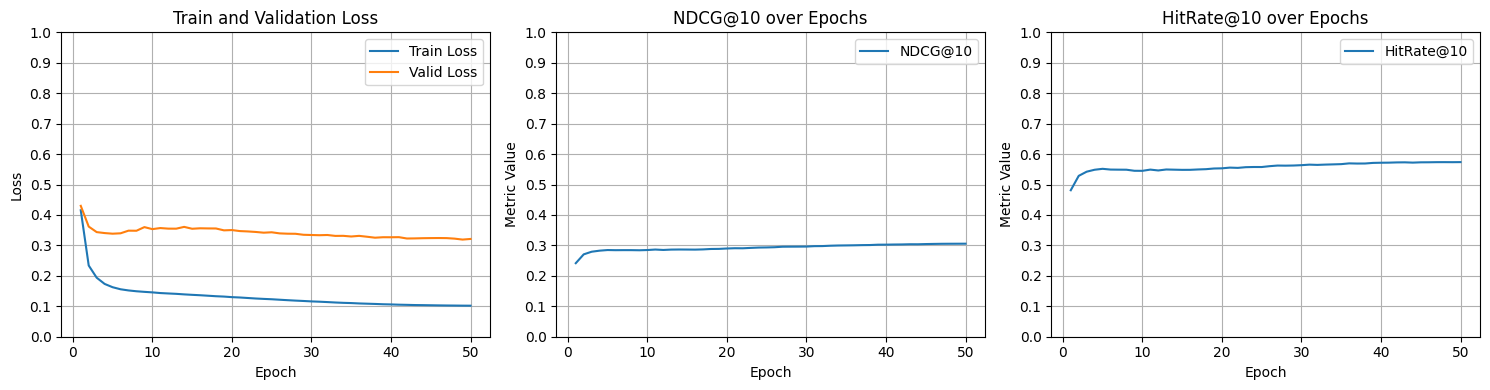

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))  # 1 hàng, 3 cột

# Create a range of epoch numbers for the x-axis
epochs_range = range(1, len(train_losses) + 1)

# --- Plot 1: Training and Validation Losses ---
axes[0].plot(epochs_range, train_losses, label='Train Loss')
axes[0].plot(epochs_range, valid_losses, label='Valid Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Train and Validation Loss')
axes[0].legend()
axes[0].grid(True)
axes[0].set_ylim(0.0, 1.0)
axes[0].set_yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

# --- Plot 2: NDCG@10 over Epochs ---
axes[1].plot(epochs_range, ndcgs_10, label='NDCG@10')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Metric Value')
axes[1].set_title('NDCG@10 over Epochs')
axes[1].legend()
axes[1].grid(True)
axes[1].set_ylim(0.0, 1.0)
axes[1].set_yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

# --- Plot 3: HitRate@10 over Epochs ---
axes[2].plot(epochs_range, hitrates_10, label='HitRate@10')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Metric Value')
axes[2].set_title('HitRate@10 over Epochs')
axes[2].legend()
axes[2].grid(True)
axes[2].set_ylim(0.0, 1.0)
axes[2].set_yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

plt.tight_layout()
plt.show()

# **6. Đánh giá khả năng xếp hạng (ranking)**

In [ ]:
model = NGCF(
    num_users = num_users,
    num_items = num_games,
    embedding_dim = 64,
    num_layers = 3,
    mess_dropout_prob = 0.4,
    node_dropout_prob = 0.6
)


# Load model with proper device mapping
model.load_state_dict(torch.load(model_dir, map_location=device))
model.to(device)  # Move model to appropriate device

NGCF(
  (embedding): Embedding(51906, 64)
  (convs): ModuleList(
    (0-2): 3 x NGCFConv()
  )
)

In [ ]:
test_data = create_leave_one_last_data(train_df, test_df, device)

# Đánh giá dựa trên leave one last
leave_one_last_result = evaluate_ranking_leave_one_last(model, test_data, device)
print("\n--- Leave One Last Ranking Metrics ---")
for metric, value in leave_one_last_result.items():
    print(f"{metric}: {value:.4f}")


--- Leave One Last Ranking Metrics ---
NDCG@10: 0.2681
HitRate@10: 0.5069
